In [ ]:
%pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00


In [ ]:

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import UGate
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import sys

#np.set_printoptions(threshold=sys.maxsize)


In [ ]:


### Determine the correct alpha of decompose_U(U)
def check_decom_U(U, answer):
  error_tol = 1e-12
  alpha, beta, gamma, delta = answer
  V = np.array([[np.exp(-1j*(alpha - beta /2 - delta/2) *np.cos(gamma / 2)),
                 -np.exp(-1j*(alpha - beta /2 + delta/2)* np.sin(gamma/2)) ],
                  [np.exp(-1j*(alpha + beta /2 - delta/2) *np.sin(gamma/2)),
                   np.exp(-1j*(alpha + beta /2 + delta/2) *np.cos(gamma/2))]])
  ret = False
  if np.allclose(U, V, atol=error_tol):
      ret = True
  return ret

### Input: U in U(2)
### Output: alpha, beta, gamma, delta in Corollary 4.2
def decompose_U(U):
  alpha = 0.5 * np.angle(np.linalg.det(U))
  V = U * np.exp(-1j*alpha)

  a, b = V[0,0], V[0,1]
  #print("(a,b)",(a,b))
  abs_a, angle_a = np.abs(a), np.angle(a)
  #print("(abs_a, angle_a)",(abs_a, angle_a))
  abs_b, angle_b = np.abs(b), np.angle(-b)
  #print("(abs_b, angle_b)",(abs_b, angle_b))
  gamma = 2 * np.arccos(np.clip(abs_a, 0, 1))
  #print("gamma",gamma)
  if np.isclose(np.sin(gamma/2), 0.0):
      beta  = 0.0
      delta  = -2*np.angle(a)
  else:
    beta = angle_b - angle_a
    delta = -angle_b - angle_a
  ret = (alpha, beta, gamma, delta)
  if not check_decom_U(U, ret):
    ret = (-alpha, beta, gamma, delta)
  #print("(alpha, beta, gamma, delta)",ret)
  return ret


### CU_gate. Input:
def CU(quantum_circuit, ctrl_bit, trgt_bit, U):
  (alpha, beta, gamma, delta) = decompose_U(U)
  #print("(alpha, beta, gamma, delta)",(alpha, beta, gamma, delta))

  # Apply circuit in the book
  quantum_circuit.u(0,0,(delta-beta)/2, trgt_bit) # The C gate
  quantum_circuit.cx(ctrl_bit, trgt_bit)
  quantum_circuit.u(-gamma/2, 0, - (delta+beta)/2, trgt_bit) # The B gate
  quantum_circuit.cx(ctrl_bit, trgt_bit)
  quantum_circuit.u(gamma/2, beta, 0, trgt_bit) # The A gate
  quantum_circuit.u(0,0,alpha, ctrl_bit) # The phase alpha

  return quantum_circuit

Every $U\in U(2)$ is written
\begin{align*}
U = e^{i\alpha} R_Z(\beta) R_Y(\gamma) R_Z(\delta)
\end{align*}

##Corollary 4.2 of Nielsen & Chuang's textbook:

Let $U = e^{i\alpha} R_Z(\beta) R_Y(\gamma) R_Z(\delta)$ where $e^{i\alpha}$ is some overall phase factor. Set
\begin{align*}
&A =  R_Z(\beta) R_Y(\gamma/2), \\
&B =  R_Y(-\gamma/2) R_Z(-(\delta+\beta)/2),  \\
&C =  R_Z((\delta - \beta)/2).   
\end{align*}
Then, we have
\begin{align*}
&A BC=I, U=e^{i\alpha} AXBXC.   
\end{align*}

## Single-qubit Control Gate CU
Let $U = e^{i\alpha} R_Z(\phi) R_Y(\theta) R_Z(\psi) \in U(2)$ be a unitary matrix, and $A,B,C$ be defined in Corollary 4.2. Then the following circuit realizes CU:



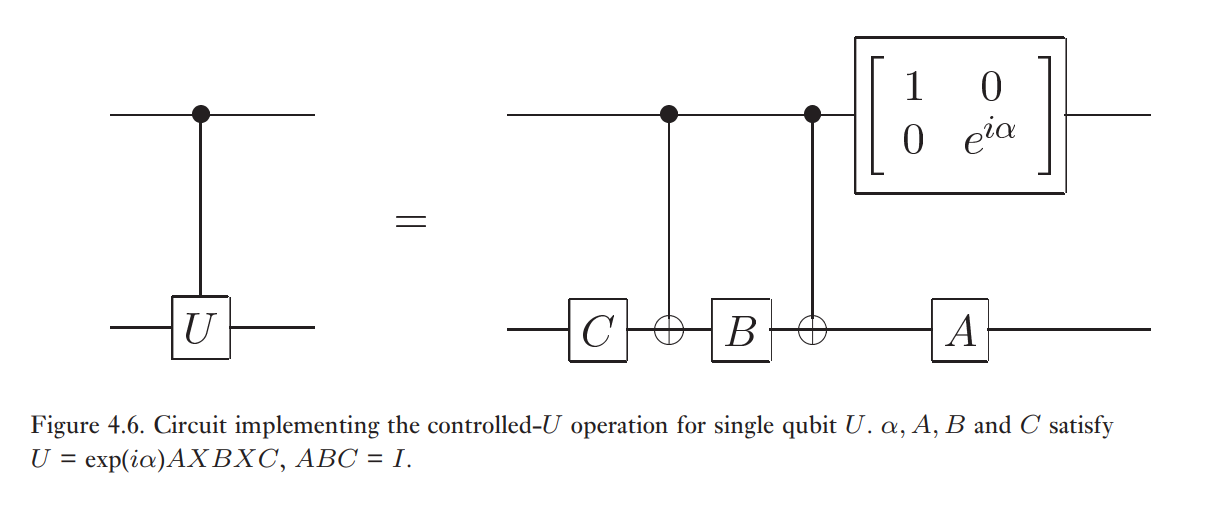

In the next chunk of code, I define following functions:

(1) check_decom_U(U, answer)

A helper function used in  decompose_U(U). It checks correctness of computation.


(2) decompose_U(U)  

It takes $U\in U(2)$ as an input and outputs a tuple $(\alpha,\beta,\gamma,\delta)$ such that
$$
U = e^{i\alpha} R_Z(\beta) R_Y(\gamma) R_Z(\delta).
$$
(3) CU(quantum_circuit, ctrl_bit, trgt_bit, U)

Inputs: quantum_circuit is the quantum ciruit. ctrl_bit, trgt_bit are the control qubit and target qubit respectively. $U\in U(2)$ is a unitary matrix.

Output: The quantum_circuit appended with CU gate with corresponding control and target qubits.


In [ ]:


### Determine the correct alpha of decompose_U(U)
def check_decom_U(U, answer):
  error_tol = 1e-12
  alpha, beta, gamma, delta = answer
  V = np.array([[np.exp(-1j*(alpha - beta /2 - delta/2) *np.cos(gamma / 2)),
                 -np.exp(-1j*(alpha - beta /2 + delta/2)* np.sin(gamma/2)) ],
                  [np.exp(-1j*(alpha + beta /2 - delta/2) *np.sin(gamma/2)),
                   np.exp(-1j*(alpha + beta /2 + delta/2) *np.cos(gamma/2))]])
  ret = False
  if np.allclose(U, V, atol=error_tol):
      ret = True
  return ret

### Input: U in U(2)
### Output: alpha, beta, gamma, delta in Corollary 4.2
def decompose_U(U):
  alpha = 0.5 * np.angle(np.linalg.det(U))
  V = U * np.exp(-1j*alpha)

  a, b = V[0,0], V[0,1]
  #print("(a,b)",(a,b))
  abs_a, angle_a = np.abs(a), np.angle(a)
  #print("(abs_a, angle_a)",(abs_a, angle_a))
  abs_b, angle_b = np.abs(b), np.angle(-b)
  #print("(abs_b, angle_b)",(abs_b, angle_b))
  gamma = 2 * np.arccos(np.clip(abs_a, 0, 1))
  #print("gamma",gamma)
  if np.isclose(np.sin(gamma/2), 0.0):
      beta  = 0.0
      delta  = -2*np.angle(a)
  else:
    beta = angle_b - angle_a
    delta = -angle_b - angle_a
  ret = (alpha, beta, gamma, delta)
  if not check_decom_U(U, ret):
    ret = (-alpha, beta, gamma, delta)
  #print("(alpha, beta, gamma, delta)",ret)
  return ret


### CU_gate. Input:
def CU(quantum_circuit, ctrl_bit, trgt_bit, U):
  (alpha, beta, gamma, delta) = decompose_U(U)
  #print("(alpha, beta, gamma, delta)",(alpha, beta, gamma, delta))

  # Apply circuit in the book
  quantum_circuit.u(0,0,(delta-beta)/2, trgt_bit) # The C gate
  quantum_circuit.cx(ctrl_bit, trgt_bit)
  quantum_circuit.u(-gamma/2, 0, - (delta+beta)/2, trgt_bit) # The B gate
  quantum_circuit.cx(ctrl_bit, trgt_bit)
  quantum_circuit.u(gamma/2, beta, 0, trgt_bit) # The A gate
  quantum_circuit.u(0,0,alpha, ctrl_bit) # The phase alpha

  return quantum_circuit

# Benchmark of single-qubit control UGate

Now, we check that out single-qubit control gate is correct:

In [ ]:

quantum_register = QuantumRegister(2, "x")

U = np.array([[0,1],[1,0]])
decompose_U(U)
quantum_circuit = QuantumCircuit(quantum_register)
quantum_circuit = CU(quantum_circuit, quantum_register[0], quantum_register[1], U)
print(np.round(Operator(quantum_circuit).data), 2)
quantum_circuit.draw()

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-0.j 0.+0.j 1.-0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.-0.j]] 2


┌─────────────┐ 
x_0: ─────────────────■───────────────────■──┤ U(0,0,-π/2) ├─
     ┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐├─────────────┴┐
x_1: ┤ U(0,0,-π/2) ├┤ X ├┤ U(-π/2,0,0) ├┤ X ├┤ U(π/2,π/2,0) ├
     └─────────────┘└───┘└─────────────┘└───┘└──────────────┘

In [ ]:

quantum_register = QuantumRegister(2, "x")


quantum_circuit = QuantumCircuit(quantum_register)
quantum_circuit.cx( quantum_register[0], quantum_register[1] )
print(np.round(Operator(quantum_circuit).data), 2)
quantum_circuit.draw()

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]] 2


x_0: ──■──
     ┌─┴─┐
x_1: ┤ X ├
     └───┘

We note that the operators of two gates match each other. Therefore, it passes the check.

# Multi-qubit Control UGate (MCU Gate)

We use the circuit provided in [Linear-depth quantum circuits for multiqubit controlled gates
](https://arxiv.org/abs/2203.11882) by Silva and  Park. Their main idea is described as follows.

We can use induction on number $n$ of control qubits to build MCU gate. Now suppose we already have the circuit for n-qubit MCU gate represented by the figure below:

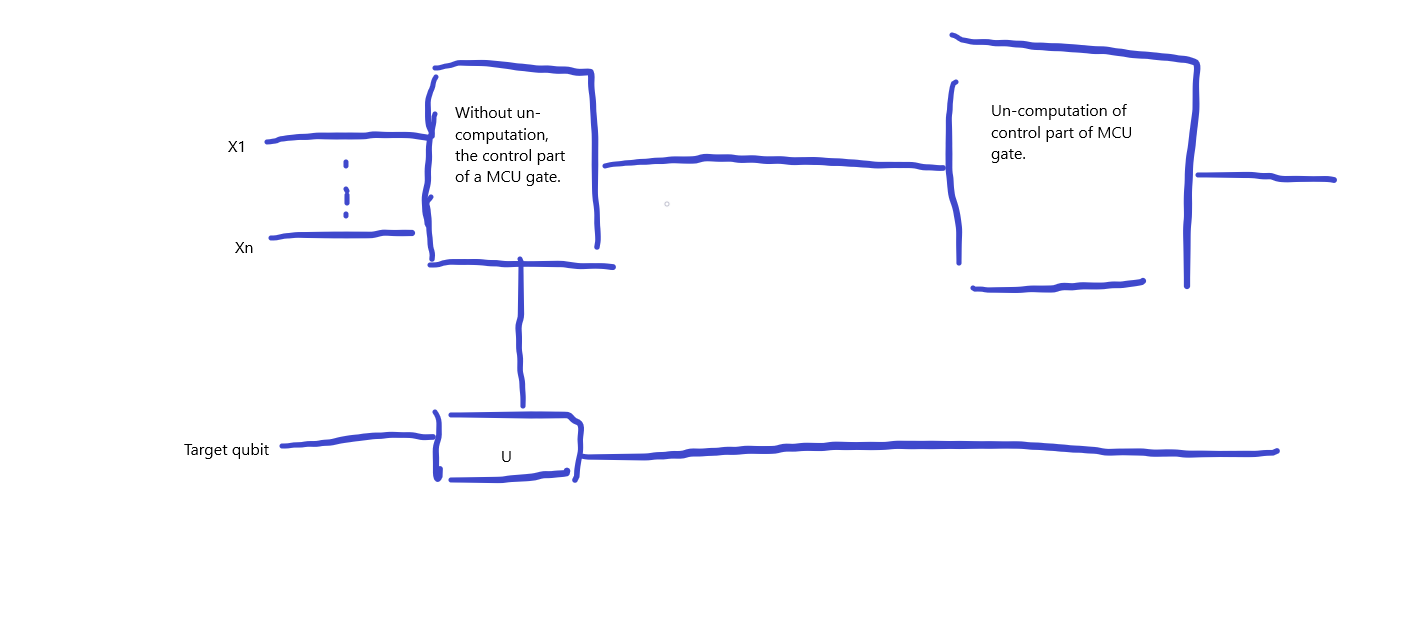

Now suppose we have $(n+1)$-th control qubit $X_{n+1}$. Then, we consider the following circuit

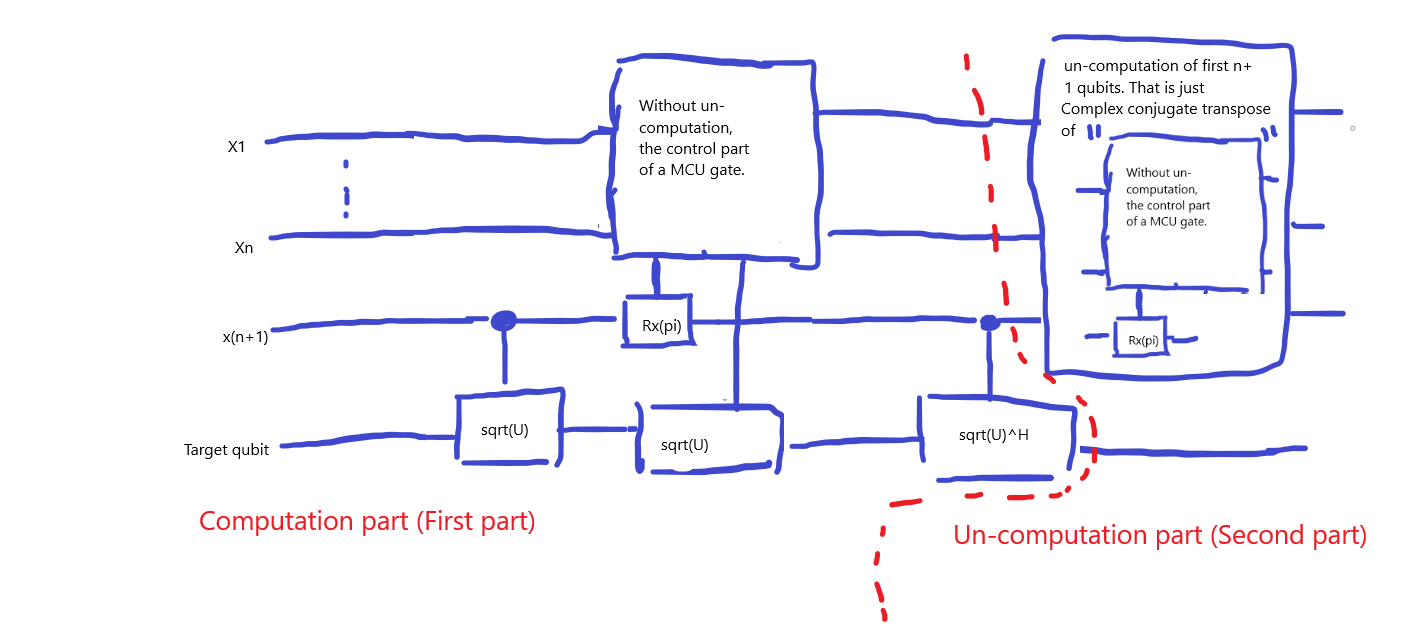

Why it works? Let's just focus on the computation part. Suppose one of $X1,\dots,Xn$ is 0. Then, the circuit becomes

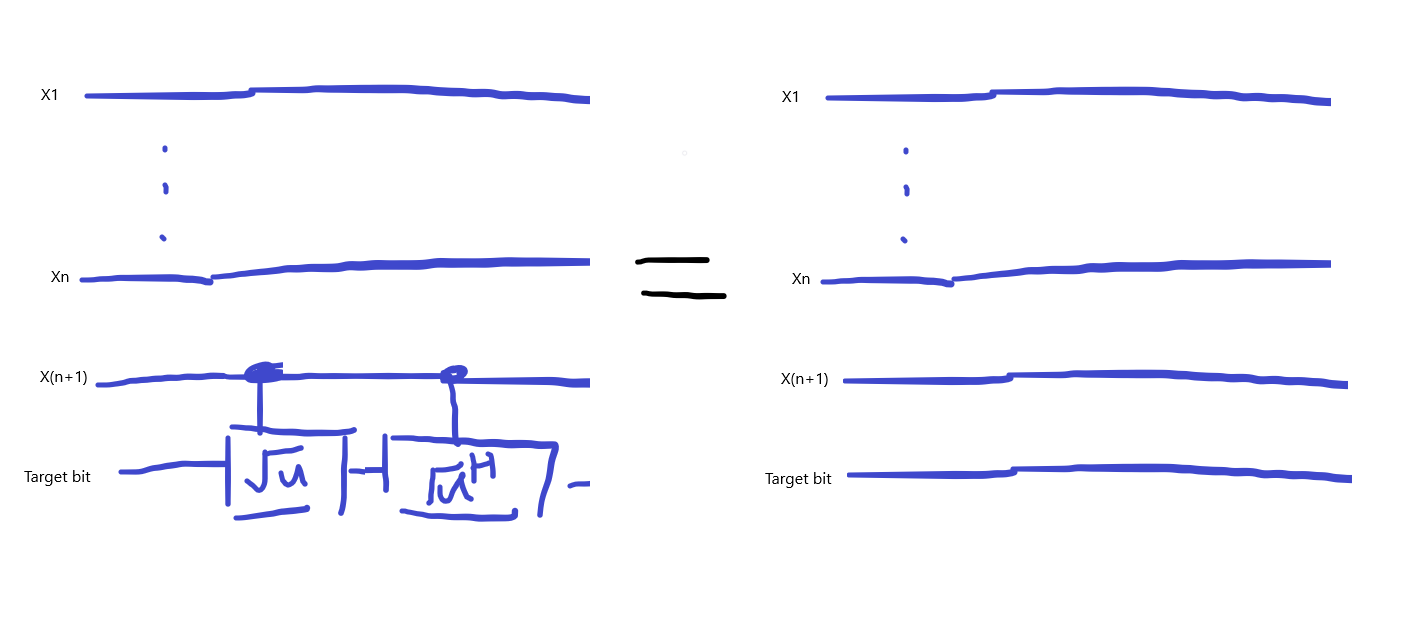

The correctness of cases that $X(n+1)=0$   follow from a similar calculation. And in the case all $X1,\dots,X(n+1) = 1$, the target bit will go through the gate $\sqrt U $ twice. Therefore, $U=(\sqrt U )^2$.

# Analysis of Complexity

## Number of ancilla

The number is 0. It is clear from the circuit.

## Circuit Depth

We compose the circuit into two parts. The first part is the computation part, and the second part is the un-computation of first $n+1$ control qubits.

The second part:

It is un-computation of the first $n+1$ qubits whose circuit is really the "reverse" of computation part of a MCU gate where there are $n$ control qubits and $X(n+1)$ is the target qubit and the controlled gate is $R_x(\pi)$. Therefore, it suffices it compute the depth of the first part.

First part:

We claim that the depth of first part is $O(n)$. By induction on $n$, we applied the $n$-bit controlled $\sqrt U$ and the $n$-bit controlled $R_x(\pi)$, and their depths are $\le Cn$ by induction hypothesis. Since they are working in parallel instead of working in series, these contribute to at most $Cn$ to the depth of the circuit. The rest part are two single-qubit controlled $\sqrt{U}$ gate and these are constant  depth, say $c_0$. WLOG, we may assume $C\ge 2c_0$. Therefore, the depth for $n+1$ control bits is
$$
Cn+2c_0\le C(n+1).
$$
Therefore, we conclude the depth of first part is $O(n)$.

Combining the depth of both parts, we conclude the depth of whole circuit is $O(n)$.

## Number of gates

We compose the circuit into two parts. The first part is the computation part, and the second part is the un-computation of first $n+1$ control qubits.

By a similar argument, we know the number of gates in the second part is the number of gates in the first part for the case of $n$ control qubits. Therefore, it suffices to count the number of gates for the first part.

We claim the number of gates in the first part is $O(n^2)$.

There is an $n$-qubit controlled $R_x(\pi)$ gate. Therefore, it uses $\le Cn^2$ gates. There is an $n$-qubit controlled $\sqrt U$ gate, but it shares the same set of control qubits as the $n$-qubit controlled $R_x(\pi)$ gate. Therefore, we just need an additional $\le C_1n$ gates to make the $n$-qubit controlled $\sqrt U$ gate. Why we just need an additional $\le C_1n$ gates? We refer to Fig 1 in [Linear-depth quantum circuits for multiqubit controlled gates
](https://arxiv.org/abs/2203.11882). The number of single-qubit controlled gates applied our target qubit grows linearly in $n$. Without loss of generality, we may assume $C\ge C_1$, then the toatl number of gates is
bounded by
$$
Cn^2 + C_1 n \le C(n+1)^2
$$

The following chunks realizes MCU. There are two functions

(1) nth_rt_uni(U,n)

Input $U\in U(2)$ and a positive integer $n$.

Output $U^{1/n}$.

Note $U\in U(2)$ can be written $U= VΛ V^T$ where the columns of $V$ consists of eigenvector of $U$ and $Λ$ is a diagonal matrix whose diagonal elements are eigenvalue. Then $U^{1/n}=VΛ^{1/n} V^T$, so $U^{1/n}$ is computed.

(2) CNU(n, U)

Input $U\in U(2)$ and a positive integer $n$.  

Output a quantum circuit of $n$ qubit controlled U gate.

In [ ]:
### Compute the nth root of a unitary matrix U
def nth_rt_uni(U,n):
  eigvals, eigvecs = np.linalg.eig(U.astype(complex))
  eigvecs = np.matrix(eigvecs)
  eigvals = eigvals
  #print(eigvecs)
  #print(eigvals)
  for i in range(len(eigvals)):
    angle = np.angle(eigvals[i])
    #print(angle)
    eigvals[i] = np.exp(1j*(angle/n))
  ret = eigvecs  @ np.diag(eigvals) @ eigvecs.H
  return ret




### Multicontrol
def CNU(n, U):
  quantum_register = QuantumRegister(n+1, "x")
  quantum_circuit = QuantumCircuit(quantum_register)
  RX_pi = np.matrix([[0,-1j],[-1j,0]])

  #quantum_circuit.draw()
  if n == 1:
    return CU(quantum_circuit, quantum_register[0], quantum_register[1], U)
    #quantum_circuit.draw()
  for i in range(n-1):
    index_of_x = (n-1) - i

    exponent_of_root = int(2**(i+1))

    root_U = nth_rt_uni(U, exponent_of_root)
    quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[n], root_U)

    for j in range(n-1, index_of_x, -1):
      exponent_of_root = int(2**(j - index_of_x))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root) #121
      quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[j], root_RX_pi)



  exponent_of_root = int(2**(n-1))
  root_U = nth_rt_uni(U, exponent_of_root)
  quantum_circuit = CU(quantum_circuit, quantum_register[0], quantum_register[n], root_U)

  for j in range(n-1, 0, -1):
      exponent_of_root = int(2**(j-1))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root) #232
      quantum_circuit = CU(quantum_circuit, quantum_register[0], quantum_register[j], root_RX_pi)


  for i in range(n-2, -1, -1):
    index_of_x = (n-1) - i

    exponent_of_root = int(2**(i+1))

    root_U_H = np.matrix(nth_rt_uni(U, exponent_of_root)).H
    quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[n], root_U_H)

    for j in range(n-1, index_of_x, -1):
      exponent_of_root = int(2**(j - index_of_x))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root)

      root_RX_minus_pi = root_RX_pi
      root_RX_minus_pi[0,1] = -root_RX_minus_pi[0,1]
      root_RX_minus_pi[1,0] = -root_RX_minus_pi[1,0]

      quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[j], root_RX_minus_pi)



  for i in range(n-1):
    index_of_x = (n-1) - i


    for j in range(n-1, index_of_x, -1):
      exponent_of_root = int(2**(j - index_of_x))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root) #1213
      quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[j], root_RX_pi)


  for j in range(n-1, 0, -1):
      exponent_of_root = int(2**(j-1))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root) #2322
      root_RX_minus_pi = root_RX_pi
      root_RX_minus_pi[0,1] = -root_RX_minus_pi[0,1]
      root_RX_minus_pi[1,0] = -root_RX_minus_pi[1,0]
      quantum_circuit = CU(quantum_circuit, quantum_register[0], quantum_register[j], root_RX_minus_pi)

  for i in range(n-2, -1, -1):
    index_of_x = (n-1) - i
    for j in range(n-1, index_of_x, -1):
      exponent_of_root = int(2**(j - index_of_x))
      root_RX_pi = nth_rt_uni(RX_pi, exponent_of_root)

      root_RX_minus_pi = root_RX_pi
      root_RX_minus_pi[0,1] = -root_RX_minus_pi[0,1]
      root_RX_minus_pi[1,0] = -root_RX_minus_pi[1,0]

      quantum_circuit = CU(quantum_circuit, quantum_register[index_of_x], quantum_register[j], root_RX_minus_pi)



  return quantum_circuit


# Benchmark of MCU Gate

Now, we check that our MCU Gate is correct:

The first example is a comparison between our circuit and built-in ccx gate

Ours:

In [ ]:
M = np.array([[0,1],[1,0]])
quantum_circuit = CNU(2, M)
op1 = np.matrix( np.round(Operator(quantum_circuit).data, 2) )
print(op1)
quantum_circuit.draw()

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j -0.+0.j  0.+0.j  0.-0.j  0.+0.j -0.-0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j -0.-0.j  0.+0.j  1.-0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.-0.j  0.+0.j -0.+0.j]]


»
x_0: ───────────────────────────────────────────────────────────────────────»
                                             ┌─────────────┐ ┌─────────────┐»
x_1: ─────────────────■───────────────────■──┤ U(0,0,-π/4) ├─┤ U(0,0,-π/2) ├»
     ┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐├─────────────┴┐├─────────────┤»
x_2: ┤ U(0,0,-π/2) ├┤ X ├┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,π/2,0) ├┤ U(0,0,-π/2) ├»
     └─────────────┘└───┘└─────────────┘└───┘└──────────────┘└─────────────┘»
«                              ┌─────────────┐               »
«x_0: ──■───────────────────■──┤ U(0,0,-π/4) ├───────■───────»
«       │                   │  └─────────────┘     ┌─┴─┐     »
«x_1: ──┼───────────────────┼──────────────────────┤ X ├─────»
«     ┌─┴─┐┌─────────────┐┌─┴─┐┌──────────────┐┌───┴───┴────┐»
«x_2: ┤ X ├┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,π/2,0) ├┤ U(0,0,π/2) ├»
«     └───┘└─────────────┘└───┘└──────────────┘└────────────┘»
«                                  ┌──────────┐                             »
«x_0: ──────────────────────■──────┤ U(0,0,0) ├─────────────────────────────»
«     ┌──────────────────┐┌─┴─┐┌───┴──────────┴───┐                         »
«x_1: ┤ U(-π/2,0,1.2732) ├┤ X ├┤ U(π/2,0.29756,0) ├──■───────────────────■──»
«     └──────────────────┘└───┘└──────────────────┘┌─┴─┐┌─────────────┐┌─┴─┐»
«x_2: ─────────────────────────────────────────────┤ X ├┤ U(-π/4,0,0) ├┤ X ├»
«                                                  └───┘└─────────────┘└───┘»
«                                                                  »
«x_0: ─────────────────────────────────■────────────────────────■──»
«       ┌────────────┐ ┌────────────┐┌─┴─┐┌──────────────────┐┌─┴─┐»
«x_1: ──┤ U(0,0,π/4) ├─┤ U(0,0,π/2) ├┤ X ├┤ U(-π/2,0,1.2732) ├┤ X ├»
«     ┌─┴────────────┴┐└────────────┘└───┘└──────────────────┘└───┘»
«x_2: ┤ U(π/4,-π/2,0) ├────────────────────────────────────────────»
«     └───────────────┘                                            »
«         ┌──────────┐   
«x_0: ────┤ U(0,0,0) ├───
«     ┌───┴──────────┴──┐
«x_1: ┤ U(π/2,-2.844,0) ├
«     └─────────────────┘
«x_2: ───────────────────
«

Built-in:

In [ ]:

quantum_register = QuantumRegister(3, "x")


quantum_circuit = QuantumCircuit(quantum_register)
quantum_circuit.ccx( quantum_register[0], quantum_register[1], quantum_register[2] )
op2 = np.matrix( np.round(Operator(quantum_circuit).data, 2) )
quantum_circuit.draw()

x_0: ──■──
       │  
x_1: ──■──
     ┌─┴─┐
x_2: ┤ X ├
     └───┘

Compare:

In [ ]:
print("Does operator of two circuit match?")
if np.linalg.norm(op1 - op2, ord='fro') < 1e-10:
  print("Yes")
else:
  print("No")

Does operator of two circuit match?
Yes




The second example is a comparison between our circuit and built-in cccx gate (by using the mcx method)

Ours:

In [ ]:
M = np.array([[0,1],[1,0]])
quantum_circuit = CNU(3, M)
op1 = np.matrix( np.round(Operator(quantum_circuit).data, 2) )
print(op1)
quantum_circuit.draw()

[[ 1.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.-0.j  0.+0.j
  -0.+0.j  0.+0.j  0.-0.j  0.+0.j -0.-0.j  0.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.-0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j
   0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j -0.-0.j  0.+0.j -0.+0.j  0.+0.j
  -0.-0.j  0.+0.j -0.+0.j  0.+0.j  0.-0.j  0.+0.j -0.-0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.-0.j  0.+0.j  0.-0.j
   0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  1.-0.j  0.+0.j -0.-0.j  0.+0.j
   0.-0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j
   0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j  0.-0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.

»
x_0: ───────────────────────────────────────────────────────────────────────»
                                                                            »
x_1: ───────────────────────────────────────────────────────────────────────»
                                             ┌─────────────┐ ┌─────────────┐»
x_2: ─────────────────■───────────────────■──┤ U(0,0,-π/4) ├─┤ U(0,0,-π/2) ├»
     ┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐├─────────────┴┐├─────────────┤»
x_3: ┤ U(0,0,-π/2) ├┤ X ├┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,π/2,0) ├┤ U(0,0,-π/2) ├»
     └─────────────┘└───┘└─────────────┘└───┘└──────────────┘└─────────────┘»
«                                                                            »
«x_0: ───────────────────────────────────────────────────────────────────────»
«                              ┌─────────────┐                               »
«x_1: ──■───────────────────■──┤ U(0,0,-π/8) ├────────■──────────────────────»
«       │                   │  └─────────────┘      ┌─┴─┐     ┌─────────────┐»
«x_2: ──┼───────────────────┼───────────────────────┤ X ├─────┤ U(-π/4,0,0) ├»
«     ┌─┴─┐┌─────────────┐┌─┴─┐┌──────────────┐┌────┴───┴────┐└─────────────┘»
«x_3: ┤ X ├┤ U(-π/8,0,0) ├┤ X ├┤ U(π/8,π/2,0) ├┤ U(0,0,-π/2) ├───────────────»
«     └───┘└─────────────┘└───┘└──────────────┘└─────────────┘               »
«                                              ┌─────────────┐               »
«x_0: ──■───────────────────────────────────■──┤ U(0,0,-π/8) ├───────■───────»
«       │                   ┌──────────┐    │  ├─────────────┤       │       »
«x_1: ──┼─────────■─────────┤ U(0,0,0) ├────┼──┤ U(0,0,-π/2) ├───────┼───────»
«       │       ┌─┴─┐     ┌─┴──────────┴─┐  │  ├─────────────┤     ┌─┴─┐     »
«x_2: ──┼───────┤ X ├─────┤ U(π/4,π/2,0) ├──┼──┤ U(0,0,-π/2) ├─────┤ X ├─────»
«     ┌─┴─┐┌────┴───┴────┐└──────────────┘┌─┴─┐├─────────────┴┐┌───┴───┴────┐»
«x_3: ┤ X ├┤ U(-π/8,0,0) ├────────────────┤ X ├┤ U(π/8,π/2,0) ├┤ U(0,0,π/2) ├»
«     └───┘└─────────────┘                └───┘└──────────────┘└────────────┘»
«                           ┌──────────┐                                    »
«x_0: ─────────────────■────┤ U(0,0,0) ├────────■───────────────────────────»
«                      │    └──────────┘      ┌─┴─┐     ┌──────────────────┐»
«x_1: ─────────────────┼──────────────────────┤ X ├─────┤ U(-π/2,0,1.2732) ├»
«     ┌─────────────┐┌─┴─┐┌──────────────┐┌───┴───┴────┐└──────────────────┘»
«x_2: ┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,π/2,0) ├┤ U(0,0,π/2) ├────────────────────»
«     └─────────────┘└───┘└──────────────┘└────────────┘                    »
«x_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«              ┌──────────┐                                              »
«x_0: ──■──────┤ U(0,0,0) ├──────────────────────────────────────────────»
«     ┌─┴─┐┌───┴──────────┴───┐                           ┌────────────┐ »
«x_1: ┤ X ├┤ U(π/2,0.29756,0) ├──■───────────────────■────┤ U(0,0,π/8) ├─»
«     └───┘└──────────────────┘  │                   │    └────────────┘ »
«x_2: ───────────────────────────┼───────────────────┼───────────────────»
«                              ┌─┴─┐┌─────────────┐┌─┴─┐┌───────────────┐»
«x_3: ─────────────────────────┤ X ├┤ U(-π/8,0,0) ├┤ X ├┤ U(π/8,-π/2,0) ├»
«                              └───┘└─────────────┘└───┘└───────────────┘»
«                                                                            »
«x_0: ───────────────────────────────────────────────────────────────────────»
«                                          ┌──────────┐                      »
«x_1: ──────■────────────────────────■─────┤ U(0,0,0) ├──────────────────────»
«         ┌─┴─┐     ┌─────────────┐┌─┴─┐┌──┴──────────┴─┐                    »
«x_2: ────┤ X ├─────┤ U(-π/4,0,0) ├┤ X ├┤ U(π/4,-π/2,0) ├──■─────────────────»
«     ┌───┴───┴────┐└─────────────┘└───┘└───────────────┘┌─┴─┐┌─────────────┐»
«x_3: ┤ U(0,0,π/2) ├──

Built-in:

In [ ]:

quantum_register = QuantumRegister(4, "x")


quantum_circuit = QuantumCircuit(quantum_register)
quantum_circuit.mcx([0,1,2], 3)
op2 = np.matrix( np.round(Operator(quantum_circuit).data, 2) )
quantum_circuit.draw()

x_0: ──■──
       │  
x_1: ──■──
       │  
x_2: ──■──
     ┌─┴─┐
x_3: ┤ X ├
     └───┘

Compare:

In [ ]:
print("Does operator of two circuit match?")
if np.linalg.norm(op1 - op2, ord='fro') < 1e-10:
  print("Yes")
else:
  print("No")

Does operator of two circuit match?
Yes
